In [1]:
import os
from pprint import pprint
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image
import ceci
import h5py
import yaml

Make sure to change your path in the next cell that leads to your TXPipe directory. See examples for IN2P3 and NERSC below.

In [2]:
#user specific paths -- IN2P3 example
my_txpipe_dir = "/pbs/home/m/mricci/throng_mricci/desc/TXPipe"

#user specific paths -- NERSC example
#my_txpipe_dir = "/pscratch/sd/a/avestruz/TXPipe"

os.chdir(my_txpipe_dir)

import txpipe

# Now let's do the same using the pipeline approach

Here we will use the 20deg2, but we can also use the 1deg2 files (just need to change 20deg2 to 1deg2 in the name of the files)

### Launching a pipeline

Let's have a look at the submission script for this pipeline:
- to work at CCin2p3 we can use: `examples/cosmodc2/1deg2-in2p3.sub`:
- to work at NERSC we can use: `examples/cosmodc2/1deg2-nersc.sub`:

If we use the CCin2p3 example :

In [3]:
! cat examples/cosmodc2/1deg2-in2p3.sub

#!/usr/bin/bash
#SBATCH --time=01:00:00
#SBATCH --partition=hpc
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=128000

source /pbs/throng/lsst/users/jzuntz/txpipe-environments/setup-txpipe
ceci examples/cosmodc2/pipeline-1deg2-CL-in2p3.yml


If we use the NERSC example:

In [4]:
! cat examples/cosmodc2/1deg2-nersc.sub

#!/bin/bash
#SBATCH -A m1727
#SBATCH -C cpu
#SBATCH --qos=debug
#SBATCH --time=00:30:00
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=32

source $CFS/lsst/groups/WL/users/zuntz/setup-txpipe
tx ceci examples/cosmodc2/pipeline-1deg2-CL-nersc.yml


This will launch a job of up to one hour (it should finish in 30 min) on a single CC-IN2P3 node to run a pipeline. After the first run, the output files are created and following runs take much less time.

In a terminal, **navigate to your TXPipe directory on IN2P3 and run**:

```
sbatch examples/cosmodc2/1deg2-in2p3.sub
```
to set it running.

If you are **on NERSC, you will instead run**:
```
sbatch examples/cosmodc2/1deg2-nersc.sub
```

Below, you will need to select the appropriate yaml file to comment/uncomment for `pipeline_file`, depending on if you are in IN2P3 or on NERSC.  

In [6]:
# Read the appropriate pipeline configuration, and ask for a flow-chart.
pipeline_file = "examples/cosmodc2/pipeline-1deg2-CL-in2p3.yml"
#pipeline_file = "examples/cosmodc2/pipeline-1deg2-CL-nersc.yml"
flowchart_file = "CL_pipeline.png"


pipeline_config = ceci.Pipeline.build_config(
    pipeline_file,
    flow_chart=flowchart_file,
    dry_run=True
)

# Run the flow-chart pipeline
ceci.run_pipeline(pipeline_config)

0

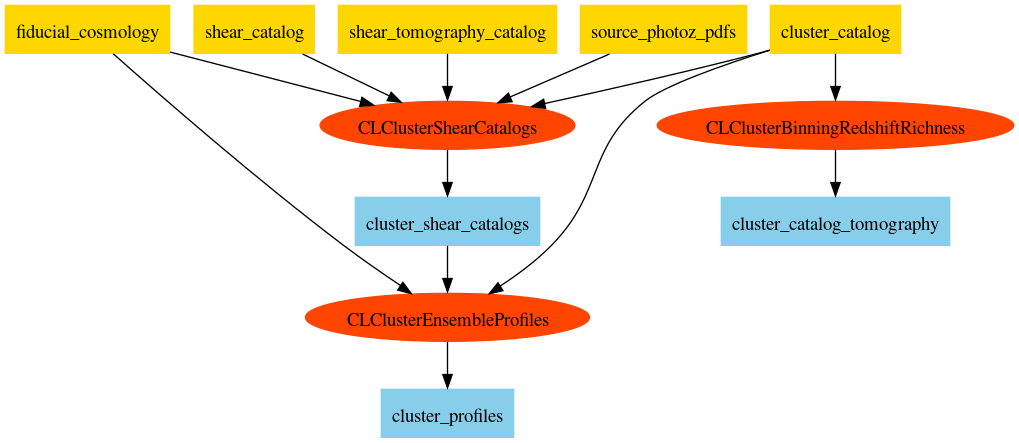

In [7]:
Image(flowchart_file)

In [8]:
f_out = h5py.File("./data/cosmodc2/outputs-1deg2-CL/cluster_profiles.hdf5", "r")

In [9]:
print(f_out.keys())

<KeysViewHDF5 ['profile', 'provenance']>


In [10]:
dat_out = f_out['provenance']
dset_out = f_out['profile']

In [11]:
print(dset_out.keys())

<KeysViewHDF5 ['profile']>


In [17]:
dset_out['profile'][:]

array([(1.19713197,  8.81975682e+12, -1.85269136e+13),
       (1.64710299,  2.29355391e+13,  1.26795467e+13),
       (2.28095121,  1.68706833e+13, -1.26165595e+13),
       (3.14362613, -7.48190460e+12,  1.82552817e+12),
       (4.33987247,  9.92254335e+10, -9.90311856e+11)],
      dtype=[('radius', '<f8'), ('tangential_comp', '<f8'), ('cross_comp', '<f8')])

In [23]:
dset_out['profile']['tangential_comp']

array([ 8.81975682e+12,  2.29355391e+13,  1.68706833e+13, -7.48190460e+12,
        9.92254335e+10])

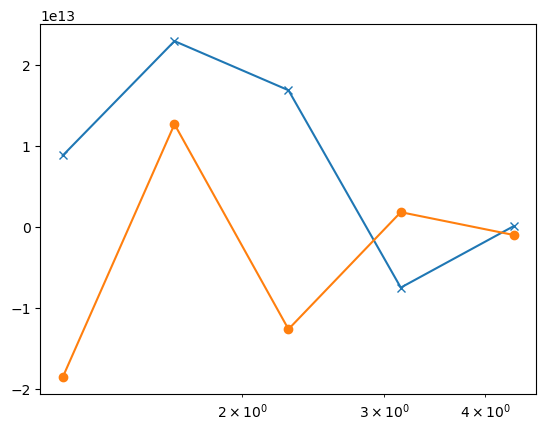

In [26]:
plt.semilogx(dset_out['profile']['radius'],dset_out['profile']['tangential_comp'],'x-')
plt.semilogx(dset_out['profile']['radius'],dset_out['profile']['cross_comp'],'o-')